# Imports

In [22]:
%run Imports.ipynb
name = 'Kred'

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier  # Ensure you have the interpret package
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance


# Data

In [24]:
key_featsubgroups = pd.read_pickle('../../pickle/2_FS/' + name + '/key_featsubgroups.pkl')
df = pd.read_pickle('../../pickle/2_FS/' + name + '/2_df_new_.pkl')

In [25]:
with open('../../pickle/4_Model_Optuna/results_dict_updated_5.pkl', 'rb') as f:
    results_dict = pickle.load(f)

In [20]:
lst = []
for key in results_dict.keys():
    print(key)
    #print(results_dict[key]['classifier'])
    # print(f'classifier: {results_dict[key]['classifier']}')
    print()
    lst.append(results_dict[key]['classifier'])

rf0

xgbc0

xgbc_optuna

xgbc_optimized

ebm_default

ebm_ben

sklearn_nn



In [21]:
lst

[RandomForestClassifier(random_state=42),
 GridSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, feature_weights=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=Non...
                          'learning_rate': [None], 'max_bin': [None],
                          'max_cat_threshold': [None],
                          'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         

In [ ]:
results_dict['rf0']['classifier'](**results_dict['rf0'])

RandomForestClassifier(random_state=42)

In [7]:
with open('../../pickle/Monedo_5/wo_optuna/ebm_best_results.pkl', "rb") as file:
    m5_fi = pickle.load(file)

In [4]:
with open('../../pickle/Monedo_7/without_optuna/results_M7_T2.pkl', "rb") as file:
    m7_fi = pickle.load(file)

In [9]:
fi5 = m5_fi['feature_importances']

In [10]:
fi7 = m7_fi['feature_importances']

In [15]:
fi_xgb = pd.read_pickle('../../outputs/importances/importances/Feat_Import_XGBoost0.pickle')
fi_rf = pd.read_pickle('../../outputs/importances/importances/rf_importances.pickle')

# Functions

1. using split data in xtrain, ytrain, xtest, ytest
2. using best parameters
3. model.fit(train)
4. feature importances
5. model.fit(test)
6. feature importances

In [13]:
def split_data_4(df, key_featsubgroups=key_featsubgroups, target=target, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets while excluding demographic features.

    Parameters:
    df (DataFrame): The dataset containing features and target variable.
    key_featsubgroups (DataFrame): A mapping of feature subgroups.
    target (str): The name of the target variable.
    test_size (float, optional): The proportion of the dataset to allocate for testing. Default is 0.2.
    random_state (int, optional): Random seed for reproducibility. Default is 42.

    Returns:
    tuple: X_train, X_test, y_train, y_test (training and testing datasets)
    """

    # Extract demographic features
    demo_feat = key_featsubgroups.loc[key_featsubgroups['subgroup'] == 'demo', 'list_features'].values[0]
    print("Demographic Features:", demo_feat)

    # Separate features (X) and target variable (y), excluding demographic features
    X = df.drop(columns=[target] + demo_feat)
    y = df[target]

    # Split the dataset into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Print dataset shapes
    print(f"Training Features Shape: {X_train.shape}")
    print(f"Training Labels Shape: {y_train.shape}")
    print(f"Testing Features Shape: {X_test.shape}")
    print(f"Testing Labels Shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

In [17]:
def instantiate_model(classifier_entry, params):
    """
    Given either a class or a fitted instance, return a fresh model with `params` applied.
    """
    # Case A: stored as a class (callable type)
    if isinstance(classifier_entry, type):
        return classifier_entry(**params)
    # Case B: stored as an instance — clone to get a fresh, unfitted model
    else:
        # clone() will copy the “template” instance, then we set new params
        model = clone(classifier_entry)
        model.set_params(**params)
        return model

In [96]:
def fi_func(data: pd.DataFrame,
            fi_train: pd.DataFrame,
            fi_test: pd.DataFrame,
            model,
            best_params: dict, col_name: str) -> (pd.DataFrame, pd.DataFrame):
    """
    Fits the given model on train and test splits, extracts feature importances,
    and appends them as columns to fi_train and fi_test.

    Parameters
    ----------
    data : pd.DataFrame
        Full dataset, with the target column included.
    fi_train : pd.DataFrame
        DataFrame indexed by feature names for train importances.
    fi_test : pd.DataFrame
        DataFrame indexed by feature names for test importances.
    model : class or GridSearchCV
        The model class or a GridSearchCV instance wrapping a model.
    best_params : dict
        Hyperparameters to pass when instantiating or setting the model.

    Returns
    -------
    fi_train, fi_test : pd.DataFrame
        Updated DataFrames with a new column of feature importances.
    """
    # 1) Split
    xtrain, xtest, ytrain, ytest = split_data_4(data)

    # 2) Train-phase fit & importance
    if isinstance(model, GridSearchCV):
        # set params and fit grid
        m_train = model.set_params(**best_params)
        m_train.fit(xtrain, ytrain)
        # unwrap best estimator
        fitrain = m_train.best_estimator_.feature_importances_
    else:
        # instantiate & fit
        m_train = model(**best_params)
        m_train.fit(xtrain, ytrain)
        # EBM vs. standard
        if isinstance(m_train, ExplainableBoostingClassifier):
            df_imp = pd.DataFrame(m_train.explain_global().data())
            print(df_imp.head())
            fitrain = df_imp['scores']
        else:
            if isinstance(m_train, MLPClassifier):
                perm = permutation_importance(m_train, xtrain, ytrain, n_repeats=50, scoring='accuracy', random_state=0, n_jobs=-1)
                print(perm.importances_mean)
                fitrain = perm.importances_mean
            else:
                fitrain = m_train.feature_importances_

    fi_train[col_name] = fitrain

    # 3) Test-phase fit & importance
    if isinstance(model, GridSearchCV):
        m_test = model.set_params(**best_params)
        m_test.fit(xtest, ytest)
        fi = m_test.best_estimator_.feature_importances_
    else:
        m_test = model(**best_params)
        m_test.fit(xtest, ytest)
        if isinstance(m_test, ExplainableBoostingClassifier):
            df_imp2 = pd.DataFrame(m_test.explain_global().data())
            fi = df_imp2['scores']
        else:
            if isinstance(m_train, MLPClassifier):
                perm1 = permutation_importance(m_test, xtest, ytest, n_repeats=50, scoring='accuracy', random_state=0, n_jobs=-1)
                print(perm1.importances_mean)
                fi = perm1.importances_mean
            else:
                fi = m_test.feature_importances_

    fi_test[col_name] = fi

    return fi_train, fi_test


# Previous Work

## Overview

In [17]:
fi_rf.head()

,Feature_RF,Importance_RF
0,kontoconnect.basicfeatures.basic_currencybalan...,0.010
1,kontoconnect.basicfeatures.basic_maxratiodaysw...,0.007
2,kontoconnect.basicfeatures.basic_maxratioposac...,0.006
3,kontoconnect.basicfeatures.basic_minsdposaccba...,0.005
4,kontoconnect.basicfeatures.basic_maxrationear0...,0.006


In [16]:
fi_xgb.head()

,Feature_XGBoost0,Importance_XGBoost0
0,kontoconnect.basicfeatures.basic_currencybalan...,0.006
1,kontoconnect.basicfeatures.basic_maxratiodaysw...,0.007
2,kontoconnect.basicfeatures.basic_maxratioposac...,0.004
3,kontoconnect.basicfeatures.basic_minsdposaccba...,0.003
4,kontoconnect.basicfeatures.basic_maxrationear0...,0.007


In [29]:
results_dict.keys()

dict_keys(['rf0', 'xgbc0', 'xgbc_optuna', 'xgbc_optimized', 'ebm_default', 'ebm_ben', 'sklearn_nn'])

In [31]:
results_dict['xgbc_optuna'].keys()

dict_keys(['classifier', 'cfm_train', 'cfm_test', 'train_accuracy', 'test_accuracy', 'train F1-score label 1', 'train F1-score label 0', 'test F1-score label 1', 'test F1-score label 0', 'test roc auc score', 'best_params', 'time_m'])

## Data Frame

In [18]:
fi_df = pd.DataFrame()
fi_df['Feature'] = fi_xgb['Feature_XGBoost0']
fi_df['XGB0'] = fi_xgb['Importance_XGBoost0']
fi_df['RF'] = fi_rf['Importance_RF']
fi_df['EBM_ben'] = fi5
fi_df['Sklearn_nn'] = fi7
fi_df.head()

,Feature,XGB0,RF,EBM_ben,Sklearn_nn
0,kontoconnect.basicfeatures.basic_currencybalan...,0.006,0.010,0.000,0.000
1,kontoconnect.basicfeatures.basic_maxratiodaysw...,0.007,0.007,0.001,0.000
2,kontoconnect.basicfeatures.basic_maxratioposac...,0.004,0.006,0.001,0.000
3,kontoconnect.basicfeatures.basic_minsdposaccba...,0.003,0.005,0.000,0.000
4,kontoconnect.basicfeatures.basic_maxrationear0...,0.007,0.006,0.000,0.000


## Correlation

In [21]:
fi_df.columns

Index(['Feature', 'XGB0', 'RF', 'EBM_ben', 'Sklearn_nn'], dtype='object')

In [23]:
corr = fi_df[['XGB0', 'RF', 'EBM_ben', 'Sklearn_nn']].corr(method='spearman')
corr

,XGB0,RF,EBM_ben,Sklearn_nn
XGB0,1.000,0.377,0.294,0.124
RF,0.377,1.000,0.113,0.233
EBM_ben,0.294,0.113,1.000,0.147
Sklearn_nn,0.124,0.233,0.147,1.000


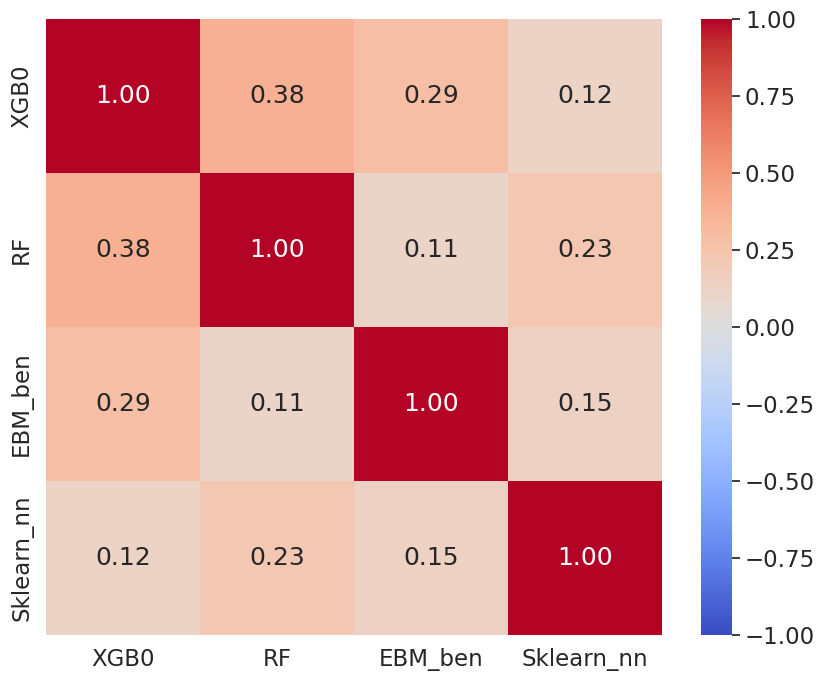

In [ ]:
plt.figure(figsize=(10, 8))                    # set figure size
sns.heatmap(
    corr,                                   # your correlation matrix
    annot=True,                                # show correlation values
    fmt=".2f",                                 # format to 2 decimal places
    cmap="coolwarm",                           # color map
    vmax=1.0, vmin=0.0,                       # set limits to emphasize scale
    square=True,
)
plt.show()

# Alternative Method

- rf0

- xgbc0

- xgbc_optuna

- xgbc_optimized

- ebm_default

- ebm_ben

- sklearn_nn

In [82]:
fi_train = pd.DataFrame()
fi_test = pd.DataFrame()

In [83]:
results_dict['rf0']['classifier']

RandomForestClassifier(random_state=42)

## Random Forest

In [84]:
bp_rf0 = results_dict['rf0']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, RandomForestClassifier, bp_rf0, 'rf0')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']
Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)


In [85]:
fi_train.head()

,rf0
0,0.010
1,0.007
2,0.006
3,0.005
4,0.006


In [86]:
fi_test.head()

,rf0
0,0.010
1,0.007
2,0.006
3,0.006
4,0.005


## XGB

### classifier

In [87]:
results_dict['xgbc0']['classifier']

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                         'learning_rate': [None], 'max_bin': [None],
                         'max_cat_threshold': [None],
                         'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         'max_depth': [None], 'max_leaves': [None],
                         'min_child_weight': [None], 'missing': [nan],
                         'monotone_constraints': [None],
                         'multi_strategy': [None], 'n_estimators': [None],
                         'n_jobs': [None], 'num_parallel_tree': [None], ...},
             return_train_score=True, scoring='accuracy', verbose=1)

In [88]:
results_dict['xgbc_optimized']['classifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [89]:
results_dict['xgbc_optuna']['classifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

### C0

In [90]:
c0_bp = results_dict['xgbc0']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, xgb.XGBClassifier, c0_bp, 'xgbc0')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']


Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)


### Optuna

In [91]:
optuna_bp = results_dict['xgbc_optuna']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, xgb.XGBClassifier, optuna_bp, 'xgb_optunga')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']
Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)


### Optimized

In [92]:
opt_bp = results_dict['xgbc_optimized']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, xgb.XGBClassifier, opt_bp, 'xgb_optimized')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']
Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)


## EBM - Ben

In [93]:
results_dict['ebm_ben']['classifier']

ExplainableBoostingClassifier(interactions=15, learning_rate=0.01,
                              max_leaves=10, min_samples_leaf=2)

In [94]:
ebm_bp = results_dict['ebm_ben']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, ExplainableBoostingClassifier, ebm_bp, 'ebm_ben')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']
Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)
         type                                              names  scores
0  univariate  kontoconnect.basicfeatures.basic_currencybalan...   0.076
1  univariate  kontoconnect.basicfeatures.basic_maxratiodaysw...   0.030
2  univariate  kontoconnect.basicfeatures.basic_maxratioposac...   0.036
3  univariate  kontoconnect.basicfeatures.basic_minsdposaccba...   0.026
4  univariate  kontoconnect.basicfeatures.

## Sklearn

In [97]:
results_dict['sklearn_nn']['classifier']

MLPClassifier(learning_rate_init=0.05, max_iter=100, random_state=0)

In [98]:
nn_bp = results_dict['sklearn_nn']['best_params']
fi_train, fi_test = fi_func(df, fi_train, fi_test, MLPClassifier, nn_bp, 'sklearn_nn')

Demographic Features: ['clientdata.demo.gender', 'clientdata.demo.age_year', 'clientdata.demo.age_month', 'clientdata.demo.children', 'clientdata.demo.children_singleparent', 'clientdata.demo.maritalstatus_expand_SINGLE', 'clientdata.demo.maritalstatus_expand_MARRIED', 'clientdata.demo.maritalstatus_expand_DIVORCED', 'clientdata.demo.maritalstatus_expand_WIDOWED', 'clientdata.demo.maritalstatus_expand_newvalue', 'clientdata.demo.maritalstatus_woe']
Training Features Shape: (103565, 406)
Training Labels Shape: (103565,)
Testing Features Shape: (25892, 406)
Testing Labels Shape: (25892,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

## saving data

In [110]:
save_path = '../../pickle/feature_importance/'

In [100]:
fi_train.head()

,rf0,xgbc0,xgb_optunga,xgb_optimized,ebm_ben,sklearn_nn
0,0.010,0.006,0.008,0.008,0.076,0.000
1,0.007,0.007,0.008,0.008,0.030,0.000
2,0.006,0.004,0.006,0.006,0.036,0.000
3,0.005,0.003,0.003,0.003,0.026,0.000
4,0.006,0.007,0.010,0.010,0.024,0.000


In [101]:
fi_test.head()

,rf0,xgbc0,xgb_optunga,xgb_optimized,ebm_ben,sklearn_nn
0,0.010,0.004,0.009,0.009,0.053,0.000
1,0.007,0.008,0.014,0.014,0.027,0.000
2,0.006,0.004,0.004,0.004,0.041,0.000
3,0.006,0.003,0.003,0.003,0.024,0.000
4,0.005,0.004,0.009,0.009,0.019,0.000


In [102]:
fi_train.to_pickle(save_path + 'train_data.pkl')

In [103]:
fi_test.to_pickle(save_path + 'test_data.pkl')

# Correlation matrix

In [104]:
corr_train = fi_train.corr(method='spearman')

In [105]:
corr_test = fi_test.corr(method='spearman')

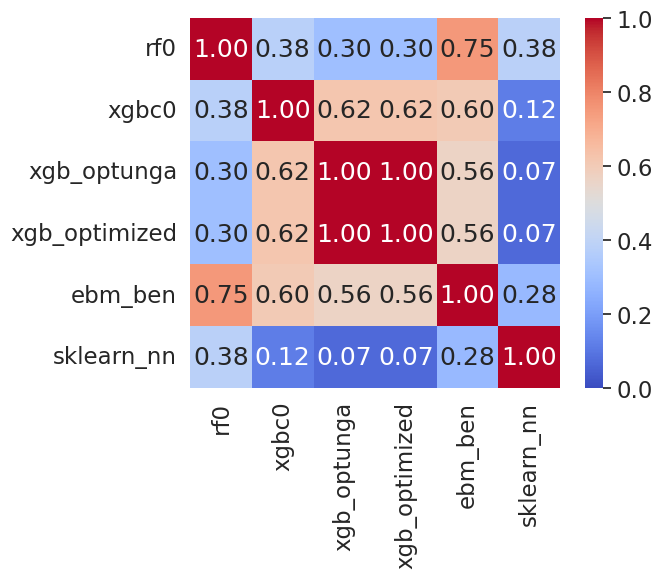

In [ ]:
sns.heatmap(corr_train, annot=True,                                # show correlation values
    fmt=".2f",                                 # format to 2 decimal places
    cmap="coolwarm",                           # color map
    vmax=1.0, vmin=0,                       # set limits to emphasize scale
    square=True)
plt.show()

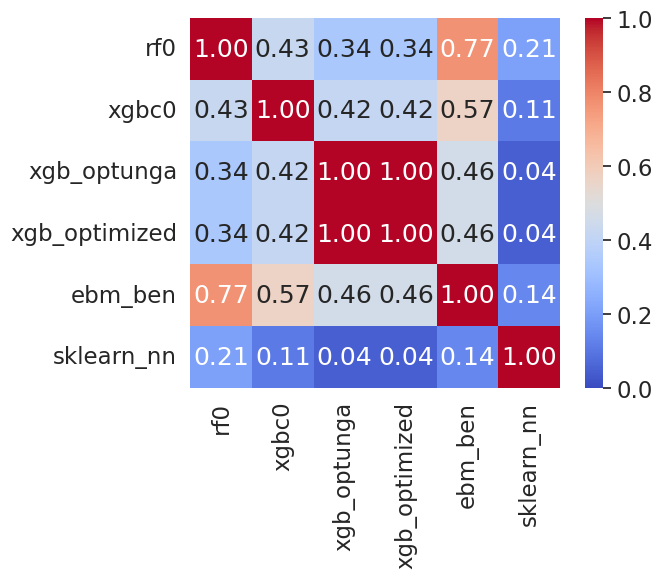

In [112]:
sns.heatmap(corr_test,annot=True,                                # show correlation values
    fmt=".2f",                                 # format to 2 decimal places
    cmap="coolwarm",                           # color map
    vmax=1.0, vmin=0,                       # set limits to emphasize scale
    square=True)
plt.show()